# Deep Learning & Art: Neural Style Transfer

### Mount google drive to fetch data

In [0]:
#!apt-get install -y libhdf5-dev
ls

emotion.py                        Images/       __pycache__/
imagenet-vgg-verydeep-16.mat      nst_utils.py
imagenet-vgg-verydeep-19-new.mat  output/


In [0]:
#Setup between colab and drive and fuse or something!!
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate


KeyboardInterrupt: ignored

In [0]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

## Load Pre-trained Model

In [0]:
model = load_vgg_model("imagenet-vgg-verydeep-19-new.mat")
print(model)

{'input': <tf.Variable 'Variable_1:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu_16:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_17:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool_5:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_18:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_19:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_6:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_20:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_21:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_22:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_23:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_7:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_24:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 

## Load Content Image

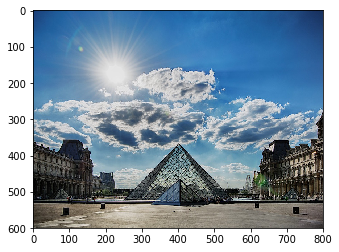

In [0]:
import imageio
content_image = imageio.imread("Images/louvre.jpg")
imshow(content_image)

In [0]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G
    a_C_unrolled = tf.reshape(a_C, [n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_C, [n_H * n_W, n_C])
    
    J_content = 1 / (4 * n_H * n_W * n_C) * tf.reduce_sum((a_C - a_G)**2)
    
    return J_content

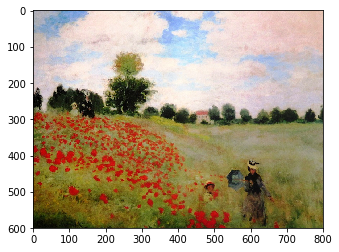

In [0]:
import imageio
style_image = imageio.imread("Images/monet_800600.jpg")
imshow(style_image)

In [0]:
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
   
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [0]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W)
    # a_S = tf.reshape(a_S, [n_C, n_H * n_W])
    # a_G = tf.reshape(a_G, [n_C, n_H * n_W])
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    # J_style_layer = (1 / (2 * n_C * n_W * n_H) ** 2) * ((tf.reduce_sum(GS - GG))** 2)
    J_style_layer = 1 / (2*n_C*n_H*n_W)**2 * tf.reduce_sum((GS-GG)**2)
    
    return J_style_layer

In [0]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [0]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [0]:
# GRADED FUNCTION: total_cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ###
    J = alpha * J_content + beta * J_style
    ### END CODE HERE ###
    
    return J

In [0]:
def generate_noise_image(content_image, noise_ratio = 0.6):
    """
    Generates a noisy image by adding random noise to the content_image
    """
        
    # Generate a random noise_image
    print(content_image.shape)
    noise_image = np.random.uniform(-20, 20, (1, 300, 400, 3)).astype('float32')
    
    print(noise_image.shape, content_image.shape)
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
W0724 13:17:54.594010 140607251687296 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 300, 400, 3)
(1, 300, 400, 3) (1, 300, 400, 3)


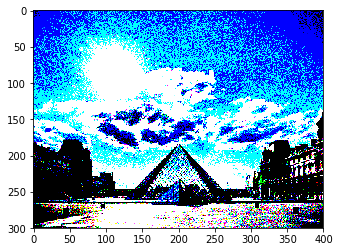

In [0]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

content_image = imageio.imread("Images/louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

style_image = imageio.imread("Images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)

generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

model = load_vgg_model("imagenet-vgg-verydeep-19-new.mat")

# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

J = total_cost(J_content, J_style, alpha = 10, beta = 40)

# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [0]:
MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
def save_image_local(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    imageio.imwrite(path, image)

# NEURAL STYLE TRANSFER

## Content Image

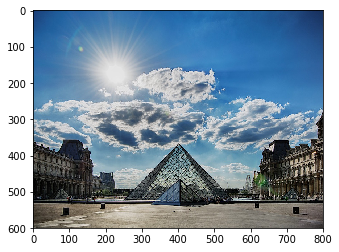

In [0]:
# load content image
content_image = imageio.imread("Images/louvre.jpg")
imshow(content_image)

## Style Template

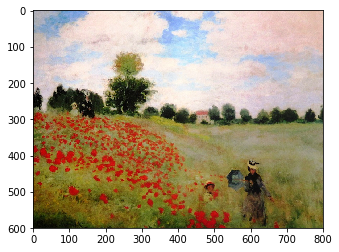

In [0]:
# load style image
style_image = imageio.imread("Images/monet_800600.jpg")
imshow(style_image)

## 0th iteration noisy-image (which will improve over each iteration)

W0724 13:26:01.851516 140607251687296 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


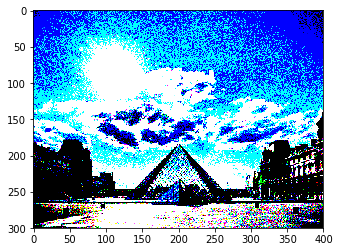

In [0]:
# 0th iteration noisy-image (which will improve over each iteration)
imshow(generated_image[0])

## Neural Style Transfer Model

In [0]:
def model_nn(sess, input_image, num_iterations = 100):
      
    # Initialize global variables (you need to run the session on the initializer)
    
    sess.run(tf.global_variables_initializer())

    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))

    for i in range(num_iterations):

        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)

        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            print("*"*20)
            # save current generated image in the "/output" directory
            save_image_local("output/" + str(i) + ".png", generated_image)

    # save last generated image
    print("Final Image Generated")
    save_image_local('output/generated_image.jpg', generated_image)
    return generated_image

## Run Model

In [0]:
%%time
output = model_nn(sess, generated_image)
print()

Iteration 0 :
total cost = 5043501000.0
content cost = 7864.0684
style cost = 126085550.0
********************
Iteration 20 :
total cost = 949066200.0
content cost = 15238.017
style cost = 23722844.0
********************
Iteration 40 :
total cost = 485625900.0
content cost = 16843.914
style cost = 12136436.0
********************
Iteration 60 :
total cost = 317137730.0
content cost = 17467.912
style cost = 7924076.0
********************
Iteration 80 :
total cost = 233324670.0
content cost = 17798.223
style cost = 5828667.0
********************
Final Image Generated

CPU times: user 4.77 s, sys: 3.31 s, total: 8.08 s
Wall time: 15.5 s


## Style Added over Iterations

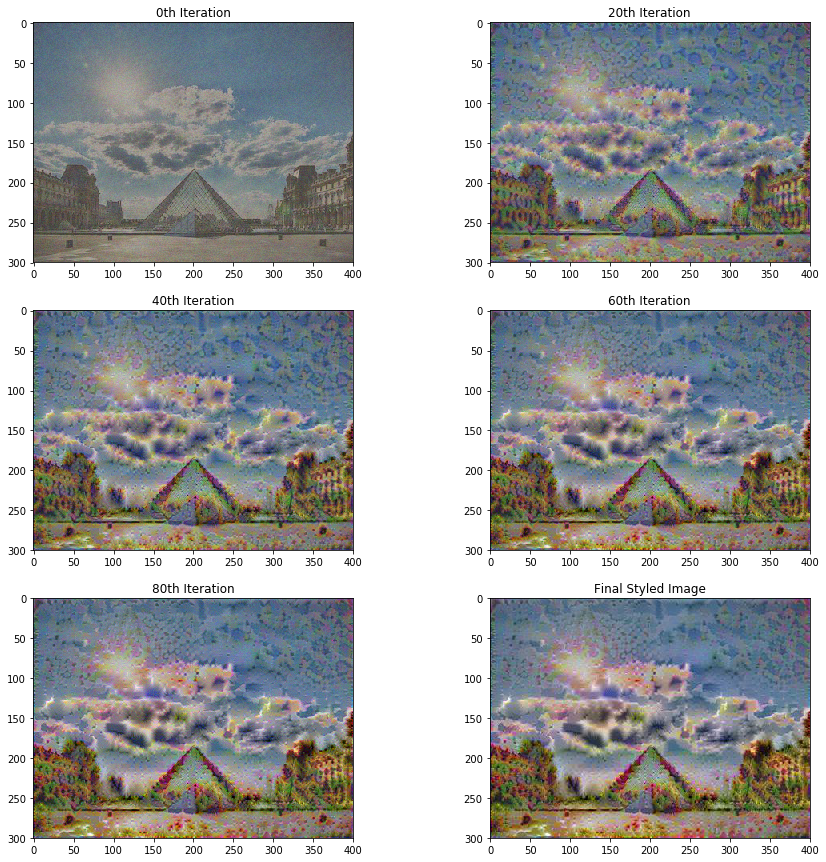

In [0]:
  w=10
  h=10
  fig=plt.figure(figsize=(15, 15))
  columns = 2
  rows = (5//columns) + 1
  
  j = 0
  
  sample_imgs = ['0.png', '20.png', '40.png', '60.png', '80.png', 'generated_image.jpg']
  
  
  for i in range(1, columns*rows +1):
#     print(i, sample_imgs[j])
    fig.add_subplot(rows, columns, i)
    try:
      img = Image.open('output/'+sample_imgs[j])
    except:
      continue
    plt.imshow(img)
    if(j != 5):
      plt.title(sample_imgs[j].split(".")[0]+"th Iteration")
    else:
      plt.title("Final Styled Image")
    j+=1
    
    if(j >= len(sample_imgs)):
      break
      
  plt.show()